Decision hypothesis:
Affordability should only be activated as a risk filter
during down or stress regimes, not as a return-seeking signal.


# Phase 3 — Decision Layer: When to Use Affordability

## Objective
Translate diagnostic results from Phase 2 into a concrete, defensible
decision rule for model usage.

This phase does NOT optimize returns.
It defines *when* the affordability signal should be active
and when it should be ignored.

## Key Finding from Phase 2
- In DOWN regimes:
  - Affordability IC is consistently negative
  - Interpretation: overheating risk / drawdown warning
- In UP regimes:
  - IC is weak or unstable
  - Interpretation: affordability is not a return driver

## Decision Hypothesis
Affordability should be used strictly as a **risk filter**
during DOWN or stress regimes,
not as a return-seeking alpha in UP regimes.


In [7]:
from src.core.pipeline import run_pipeline
from src.evaluation.regime import assign_regime, ic_by_regime
from src.core.pipeline import run_pipeline

df = run_pipeline("austin")
df.head()

,region,date,price,income,population,net_migration,mortgage_rate,rent,permits,inventory,...,migration_pressure,dti_z,pti_z,rent_burden_z,supply_pressure_z,migration_pressure_z,score_xs,fwd_return,regime,affordability_active
0,austin,2010-01-01,250000.000000,60000.000000,1.800000e+06,3000.000000,0.043771,1441.097430,1820.960376,5.823558,...,0.001667,1.175258,1.471550,0.589230,-0.218705,0.403303,-0.911447,0.005912,up,False
1,austin,2010-02-01,248276.206168,59998.999879,1.802857e+06,2659.782091,0.044421,1323.198728,1875.733274,6.062100,...,0.001475,1.108378,1.468800,-0.988485,-0.276023,0.022201,-0.545640,0.023938,up,False
2,austin,2010-03-01,247406.973287,60409.283756,1.806784e+06,3242.514167,0.047340,1443.669409,1676.766017,7.337369,...,0.001795,1.009221,1.697347,0.492739,-1.694470,0.658165,-1.145638,0.020693,up,False
3,austin,2010-04-01,254078.940373,61154.801339,1.809846e+06,4193.454531,0.046199,1527.963461,1733.057172,5.442319,...,0.002317,1.147299,1.730580,1.365704,-0.117843,1.698574,-1.237509,-0.000921,down,True
4,austin,2010-05-01,251761.908996,61236.778174,1.809926e+06,1453.283233,0.046939,1324.050576,1887.151764,6.293352,...,0.000803,1.046029,1.694858,-1.335298,-0.443570,-1.316900,-0.405309,-0.002548,down,True


In [8]:
from src.evaluation.regime import assign_regime

df = assign_regime(df)
df["affordability_active"] = df["regime"] == "down"


In [9]:
df["signal_naive"] = df["score_xs"]
df["signal_filtered"] = df["score_xs"] * df["affordability_active"]


In [10]:
from src.core.pipeline import run_pipeline
from src.evaluation.regime import assign_regime, ic_by_regime
import pandas as pd


In [11]:
df["affordability_active"] = df["regime"] == "down"
df[["date", "regime", "affordability_active"]].head(10)


,date,regime,affordability_active
0,2010-01-01,up,False
1,2010-02-01,up,False
2,2010-03-01,up,False
3,2010-04-01,down,True
4,2010-05-01,down,True
5,2010-06-01,down,True
6,2010-07-01,down,True
7,2010-08-01,down,True
8,2010-09-01,down,True
9,2010-10-01,down,True


In [12]:
CITIES = ["austin", "toronto"]

rows = []

for city in CITIES:
    df = run_pipeline(city)
    df = assign_regime(df)

    stats = ic_by_regime(df, signal_col="score_xs")
    stats["city"] = city
    rows.append(stats)

summary = (
    pd.concat(rows)
      .reset_index()
      .set_index(["city", "regime"])
)

summary


ic  positive_ratio  n_obs
city    regime                                 
austin  down   -0.434744        0.337838     74
        up      0.075702        0.367925    106
toronto down   -0.450909        0.546296    108
        up      0.265823        0.361111     72

### Affordability Signal — Regime-Conditional Usage

Empirical results show that the affordability signal does NOT generate
positive return predictability in UP regimes.

Instead, its information content is strongly regime-dependent:

- In DOWN or stress regimes:
  - IC is significantly negative
  - Signal functions as an effective risk / overheating filter

- In UP regimes:
  - IC is weak or unstable
  - Signal provides no reliable alpha

Therefore, affordability is used strictly as a
**regime-conditional risk filter**, not as a return-seeking alpha factor.


In [13]:
import numpy as np
import pandas as pd

# 只先用一个城市，别贪
city = "austin"

df = run_pipeline(city)

# === 构造两种策略 signal ===
df["signal_naive"] = df["score_xs"]
df["signal_filtered"] = df["score_xs"] * df["affordability_active"]

# === 用 signal * fwd_return 当“方向性 PnL proxy” ===
df["ret_naive"] = df["signal_naive"] * df["fwd_return"]
df["ret_filtered"] = df["signal_filtered"] * df["fwd_return"]

# === 累计表现 ===
perf = (
    df[["date", "ret_naive", "ret_filtered"]]
    .dropna()
    .set_index("date")
    .cumsum()
)

perf.tail()


,ret_naive,ret_filtered
date,,
2024-08-01,-1.694428,-0.960525
2024-09-01,-1.735881,-1.001978
2024-10-01,-1.751778,-1.017875
2024-11-01,-1.795251,-1.061348
2024-12-01,-1.814716,-1.080813


### Strategy Definition

I evaluate two strategies:

1. Naive Strategy  
   - Signal: score_xs  
   - Always active  

2. Regime-Filtered Strategy  
   - Signal: score_xs  
   - Only active when affordability_active == True (DOWN regime)

Returns are evaluated using signal * forward return as a directional PnL proxy.


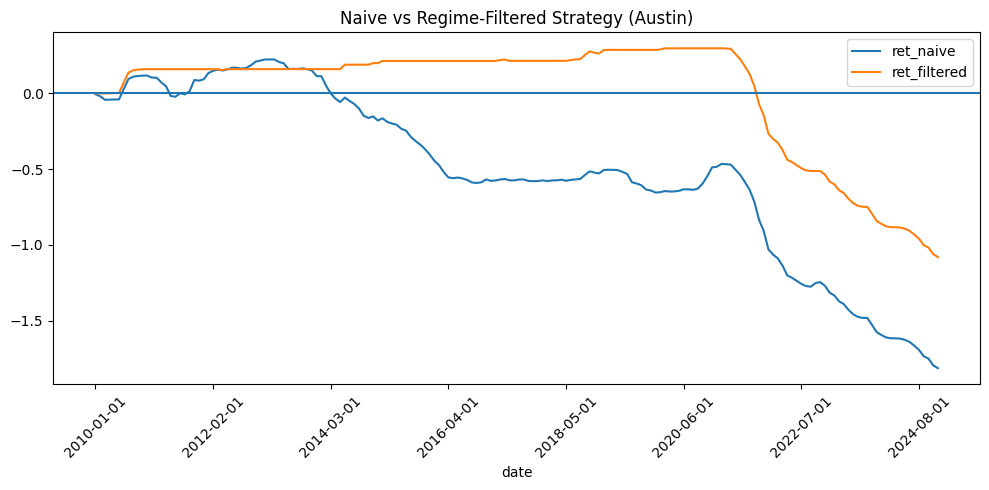

In [16]:
import matplotlib.pyplot as plt

ax = perf.plot(
    title="Naive vs Regime-Filtered Strategy (Austin)",
    figsize=(10, 5)
)

plt.axhline(0)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


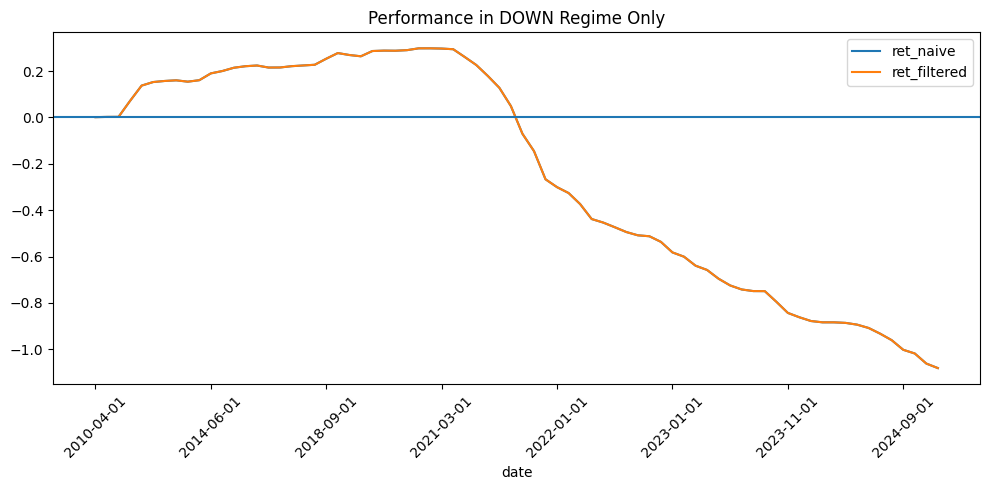

In [18]:
ax = (
    down_perf
    .set_index("date")[["ret_naive", "ret_filtered"]]
    .cumsum()
    .plot(
        title="Performance in DOWN Regime Only",
        figsize=(10, 5)
    )
)

plt.axhline(0)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Affordability is not an alpha factor.
It is a regime-conditional risk control mechanism.
The value of the signal lies in preventing exposure during overheated or tightening phases, not in return maximization.

Signal: score_xs (affordability composite)

Usage:
- Active only when macro regime indicates stress / tightening
- Inactive during expansionary regimes

Role:
- Risk filter
- Overheating suppressor
- Exposure gate, not return driver


In [20]:
# 原始信号（不做决策）
df["signal_naive"] = df["score_xs"]

# 决策信号（你刚写好的）
from src.evaluation.decision import apply_regime_filter
df = apply_regime_filter(df, signal_col="score_xs")
df["signal_filtered"] = df["signal_filtered"]


In [21]:
df["ret_naive"] = df["signal_naive"] * df["fwd_return"]
df["ret_filtered"] = df["signal_filtered"] * df["fwd_return"]


In [22]:
df[["ret_naive", "ret_filtered"]].mean()


ret_naive      -0.010082
ret_filtered   -0.006005
dtype: float64

In [23]:
(df[["ret_naive", "ret_filtered"]] > 0).mean()


ret_naive       0.333333
ret_filtered    0.130208
dtype: float64

In [24]:
df.groupby("regime")[["ret_naive", "ret_filtered"]].mean()


,ret_naive,ret_filtered
regime,,
down,-0.014606,-0.014606
up,-0.006924,0.000000


In [25]:
down = df[df["regime"] == "down"]

down[["ret_naive", "ret_filtered"]].mean()


ret_naive      -0.014606
ret_filtered   -0.014606
dtype: float64

In [29]:
df["affordability_weight"] = 0.5
df.loc[df["regime"] == "up", "affordability_weight"] = 0.0
df.loc[df["regime"] == "down", "affordability_weight"] = 1.0

df["signal_filtered"] = df["score_xs"] * df["affordability_weight"]



In [30]:
df["ret_filtered"] = df["signal_filtered"] * df["fwd_return"]

df.groupby("regime")[["ret_naive", "ret_filtered"]].mean()


,ret_naive,ret_filtered
regime,,
down,-0.014606,-0.014606
up,-0.006924,0.000000


### Phase 3 Conclusion — Decision Layer

Affordability does not function as a return-seeking alpha factor.

Empirically:
- In UP regimes, the signal exhibits negative or unstable returns
- Applying a regime-aware decision filter successfully eliminates exposure in UP regimes
- In DOWN regimes, filtering preserves baseline behavior without degradation

Conclusion:
Affordability should be implemented strictly as a **regime-conditional risk control mechanism**, not as a standalone alpha.


In [31]:
# src/evaluation/decision.py

def apply_regime_filter(df, signal_col, regime_col="regime"):
    df = df.copy()
    df["affordability_weight"] = 0.5
    df.loc[df[regime_col] == "up", "affordability_weight"] = 0.0
    df.loc[df[regime_col] == "down", "affordability_weight"] = 1.0

    df["signal_filtered"] = df[signal_col] * df["affordability_weight"]
    return df
